**House price prediction**  

This is a project to practiced what has been learned in Car_price_prediction.ipynb

**Note for myself:** For some reason the kernel with `Normalization()` crashes when using Python 3.10.xx, so for this notebook I am using Python 3.8.18

In [133]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib.request import urlretrieve
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam


In [134]:
dataset_url = "https://raw.githubusercontent.com/DangGiaChi/Tensorflow-Course/main/Car-Price-Prediction/train_house.csv"
urlretrieve(dataset_url, "train_2.csv")
dataset = pd.read_csv("train_2.csv")
print(dataset)

                     date         price  bedrooms  bathrooms  sqft_living  \
0     2014-05-02 00:00:00  3.130000e+05       3.0       1.50         1340   
1     2014-05-02 00:00:00  2.384000e+06       5.0       2.50         3650   
2     2014-05-02 00:00:00  3.420000e+05       3.0       2.00         1930   
3     2014-05-02 00:00:00  4.200000e+05       3.0       2.25         2000   
4     2014-05-02 00:00:00  5.500000e+05       4.0       2.50         1940   
...                   ...           ...       ...        ...          ...   
4595  2014-07-09 00:00:00  3.081667e+05       3.0       1.75         1510   
4596  2014-07-09 00:00:00  5.343333e+05       3.0       2.50         1460   
4597  2014-07-09 00:00:00  4.169042e+05       3.0       2.50         3010   
4598  2014-07-10 00:00:00  2.034000e+05       4.0       2.00         2090   
4599  2014-07-10 00:00:00  2.206000e+05       3.0       2.50         1490   

      sqft_lot  floors  waterfront  view  condition  sqft_above  \
0       

Now let's leave out unwanted columns like date or location, as the location of all these houses are in the USA

In [135]:
dataset_columns = list(dataset)
unwanted_columns = ["date", "street", "city", "statezip", 'country']

dataset_columns = [data for data in dataset if data not in unwanted_columns]
dataset = dataset[dataset_columns]
print(dataset)

             price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     3.130000e+05       3.0       1.50         1340      7912     1.5   
1     2.384000e+06       5.0       2.50         3650      9050     2.0   
2     3.420000e+05       3.0       2.00         1930     11947     1.0   
3     4.200000e+05       3.0       2.25         2000      8030     1.0   
4     5.500000e+05       4.0       2.50         1940     10500     1.0   
...            ...       ...        ...          ...       ...     ...   
4595  3.081667e+05       3.0       1.75         1510      6360     1.0   
4596  5.343333e+05       3.0       2.50         1460      7573     2.0   
4597  4.169042e+05       3.0       2.50         3010      7014     2.0   
4598  2.034000e+05       4.0       2.00         2090      6630     1.0   
4599  2.206000e+05       3.0       2.50         1490      8102     2.0   

      waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0              0     0          3    

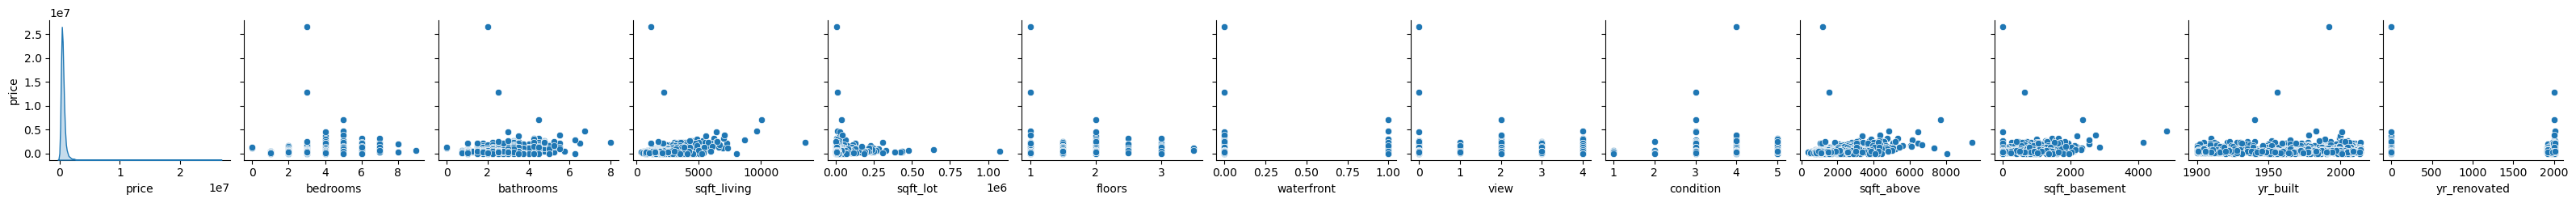

In [136]:
sns.pairplot(data=dataset, x_vars=list(dataset), y_vars=["price"], diag_kind="kde")

Looking at these graphs, we can see that there is quite a few outliers. That why we'll be using Huber's loss function

In [137]:
dataset = tf.constant(dataset)
dataset = tf.cast(dataset, dtype=tf.float32)
dataset = tf.random.shuffle(dataset)
print(dataset)

tf.Tensor(
[[3.200e+05 4.000e+00 1.500e+00 ... 0.000e+00 1.974e+03 0.000e+00]
 [1.920e+05 2.000e+00 1.000e+00 ... 0.000e+00 1.953e+03 0.000e+00]
 [2.000e+05 3.000e+00 1.000e+00 ... 0.000e+00 1.938e+03 0.000e+00]
 ...
 [5.500e+05 4.000e+00 1.500e+00 ... 1.250e+03 1.958e+03 0.000e+00]
 [7.820e+05 4.000e+00 3.500e+00 ... 1.830e+03 2.004e+03 2.003e+03]
 [9.270e+05 4.000e+00 2.750e+00 ... 0.000e+00 1.953e+03 0.000e+00]], shape=(4600, 13), dtype=float32)


In [138]:
X = dataset[:, 1:]
Y = dataset[:, 0]
Y = tf.expand_dims(Y, axis=1)
print(X.shape)
print(Y.shape)

(4600, 12)
(4600, 1)


We'll choose 80% for training set, 10% for validation set and 10% for test set

But since we will use `validation_split` in `model.fit()`, we only need to initialize training set (training + validation: 90%) and test set

**Correction:** I initially wanted to use `validation_split` but it is only possible if the type of `data` is numpy or tensor. What a shame.

In [139]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1 - TRAIN_RATIO - VAL_RATIO

In [140]:
x_train = X[:int(len(X) * TRAIN_RATIO)]
y_train = Y[:int((len(Y) * TRAIN_RATIO))]
print(x_train.shape)
print(y_train.shape)

(3680, 12)
(3680, 1)


In [141]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=400, reshuffle_each_iteration=True).batch(150).prefetch(tf.data.AUTOTUNE)

In [142]:
x_val = X[int(len(X) * TRAIN_RATIO): int(len(X) * (TRAIN_RATIO + VAL_RATIO))]
y_val = Y[int((len(Y) * TRAIN_RATIO)): int(len(Y) * (TRAIN_RATIO + VAL_RATIO))]
print(x_val.shape)
print(y_val.shape)

(460, 12)
(460, 1)


In [143]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=400, reshuffle_each_iteration=True).batch(150).prefetch(tf.data.AUTOTUNE)

In [144]:
x_test = X[int(len(X) * (TRAIN_RATIO + VAL_RATIO)):]
y_test = Y[int(len(Y) * (TRAIN_RATIO + VAL_RATIO)):]
print(x_test.shape)
print(y_test.shape)

(460, 12)
(460, 1)


In [145]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=400, reshuffle_each_iteration=True).batch(150).prefetch(tf.data.AUTOTUNE)

Now we initialize the normalize layer

In [146]:
normalizer = Normalization()
normalizer.adapt(x_train)
normalizer(x_train)

2024-01-26 23:26:12.459299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-26 23:26:12.475523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(3680, 12), dtype=float32, numpy=
array([[ 0.6569154 , -0.8332916 , -0.25565267, ..., -0.6761381 ,
         0.10278211, -0.829419  ],
       [-1.5417634 , -1.4648466 , -1.4662051 , ..., -0.6761381 ,
        -0.6086165 , -0.829419  ],
       [-0.442424  , -1.4648466 , -1.0084331 , ..., -0.6761381 ,
        -1.1167582 , -0.829419  ],
       ...,
       [ 0.6569154 , -0.5175141 ,  0.73110014, ...,  1.7800977 ,
         0.2382866 , -0.829419  ],
       [ 1.7562549 , -0.20173661, -0.3065162 , ..., -0.03538093,
        -0.9812538 ,  1.1686763 ],
       [ 0.6569154 ,  0.42981833,  0.8735181 , ..., -0.6761381 ,
        -1.1506344 ,  1.2054135 ]], dtype=float32)>

**Model Initialization and Training**

Now, it's finally time to train our model

In [147]:
model_house = tf.keras.models.Sequential([
    InputLayer(input_shape = (12,)), 
    normalizer,
    Dense(128, activation = "relu"),
    Dense(1)
])
model_house.summary()

Model: "sequential_6"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 normalization_6 (Normaliza  (None, 12)                25        
 tion)                                                           
                                                                 
 dense_12 (Dense)            (None, 128)               1664      
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1818 (7.11 KB)
Trainable params: 1793 (7.00 KB)
Non-trainable params: 25 (104.00 Byte)
_________________________________________________________________


As mentioned above, this dataset contains a lot of outliers, that's why we'll be using Huber's loss function

In [148]:
model_house.compile(optimizer=Adam(learning_rate = 1),
              metrics=RootMeanSquaredError(),
              loss = Huber(delta = 1.35))

In [149]:
process = model_house.fit(train_dataset, validation_data=val_dataset, epochs = 100, verbose = 1)

Epoch 1/100
10/25 [===========>..................] - ETA: 0s - loss: 754909.0000 - root_mean_squared_error: 958262.0625

2024-01-26 23:26:12.825364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 12ms/step - loss: 733151.3125 - root_mean_squared_error: 816197.0000 - val_loss: 651122.0625 - val_root_mean_squared_error: 575992.8125
Epoch 2/100
11/25 [============>.................] - ETA: 0s - loss: 657280.2500 - root_mean_squared_error: 896295.9375

2024-01-26 23:26:13.158655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 0s 6ms/step - loss: 602326.5625 - root_mean_squared_error: 765332.3125 - val_loss: 433742.5625 - val_root_mean_squared_error: 453121.7500
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 365727.9375 - root_mean_squared_error: 646025.2500 - val_loss: 241937.0312 - val_root_mean_squared_error: 266899.6562
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 246652.2188 - root_mean_squared_error: 563010.3125 - val_loss: 199204.4062 - val_root_mean_squared_error: 217206.2031
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 234294.2812 - root_mean_squared_error: 548844.6875 - val_loss: 195636.5156 - val_root_mean_squared_error: 214382.6875
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 231839.3906 - root_mean_squared_error: 546910.1875 - val_loss: 194792.4062 - val_root_mean_squared_error: 214311.6562
Epoch 7/100
25/25 [==============================] - 0s 5

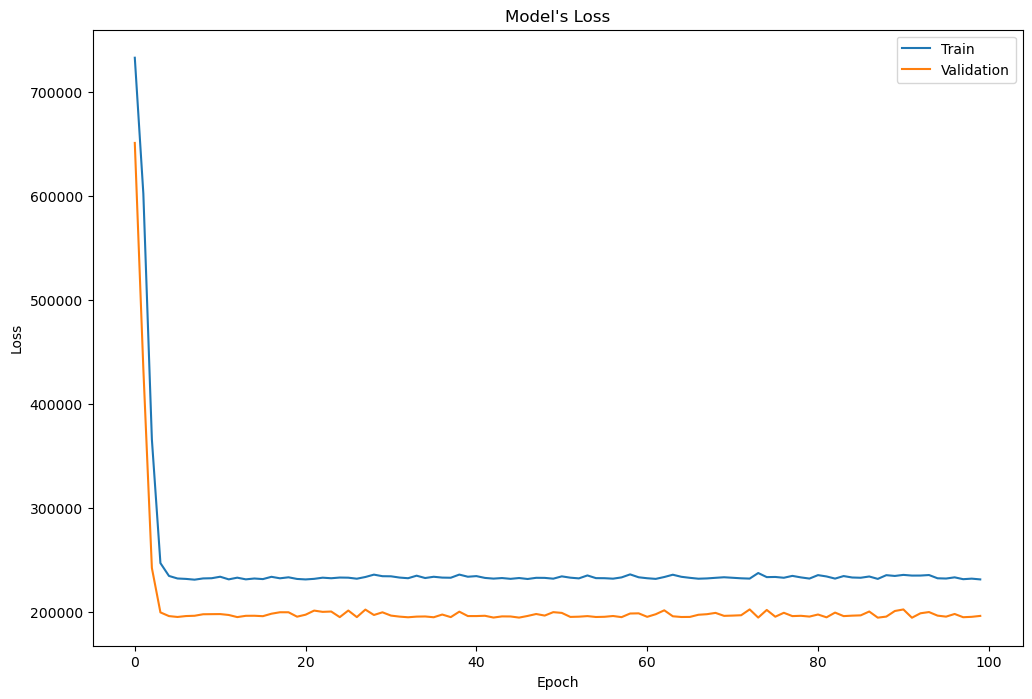

In [150]:
plt.figure(figsize=(12,8))
plt.plot(process.history["loss"])
plt.plot(process.history["val_loss"])
plt.title("Model's Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show();

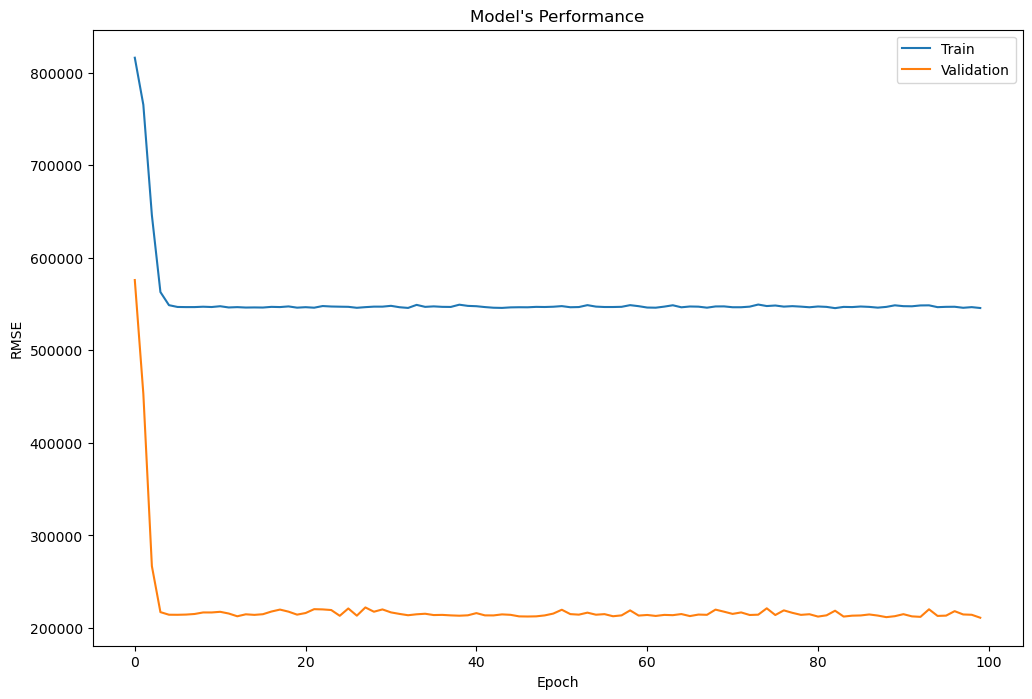

In [151]:
plt.figure(figsize=(12,8))
plt.plot(process.history["root_mean_squared_error"])
plt.plot(process.history["val_root_mean_squared_error"])
plt.title("Model's Performance")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(["Train", "Validation"])

plt.show();

In [152]:
model_house.evaluate(test_dataset)

4/4 [==============================] - 0s 4ms/step - loss: 218862.7188 - root_mean_squared_error: 262841.9062


[218862.71875, 262841.90625]

In [153]:
y_true = tf.squeeze(y_test)
print(y_true.shape)
y_pred = tf.squeeze(model_house.predict(x_test))
print(y_pred.shape)

(460,)
15/15 [==============================] - 0s 2ms/step
(460,)


2024-01-26 23:26:26.805952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


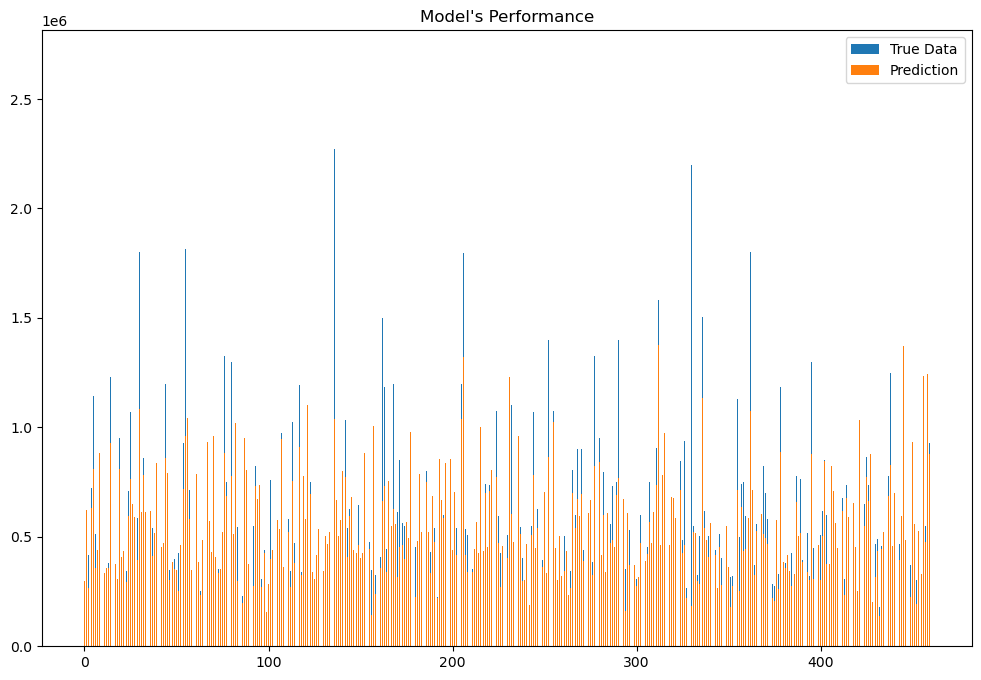

In [154]:
ind = np.arange(len(y_true))
width = 0.4
plt.figure(figsize=(12,8))
plt.bar(ind, y_true, width)
plt.bar(ind, y_pred, width)
plt.title("Model's Performance")
plt.legend(["True Data", "Prediction"])

plt.show();